## Convolution Neural Networks on Fashion

In [352]:
# Importing Fashion MNIST data & loading training & test sets
from keras.datasets import fashion_mnist
(train_X,train_Y), (test_X,test_Y) = fashion_mnist.load_data()



In [353]:
print('Training data shape', train_X.shape, train_Y.shape)
print('Test data shape', test_X.shape, test_Y.shape)

Training data shape (60000, 28, 28) (60000,)
Test data shape (10000, 28, 28) (10000,)


In [354]:
import numpy as np
uniq_classes = np.unique(train_Y)
n_classes = len(uniq_classes)
print('Total no. of outputs :', n_classes)
print('Output classes :', uniq_classes)

Total no. of outputs : 10
Output classes : [0 1 2 3 4 5 6 7 8 9]


#### Looking at the images in the dataset

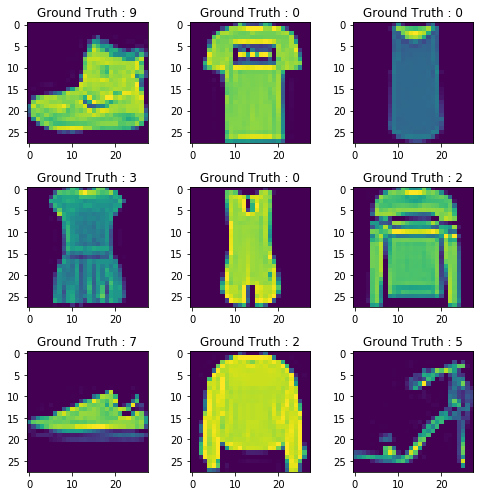

In [355]:
%matplotlib inline 

plt.figure(figsize=[7,7])
for i in range(9):    
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(train_X[i,:,:])
    plt.title("Ground Truth : {}".format(train_Y[i]))


## Data Preprocessing

The methods in the layers module for creating convolutional and pooling layers for two-dimensional image data expect input tensors to have a shape of [batch_size, image_height, image_width, channels] by default. Fashion-MNIST dataset is composed of monochrome 28x28 pixel images, so the desired shape for our input layer is [batch_size, 28, 28, 1]

In [356]:
# We will reshape our data to the desired shape for our input layer.
train_X = train_X.reshape(-1, 28,28,1)
test_X = test_X.reshape(-1,28,28,1)

print('Training data shape', train_X.shape, train_Y.shape)
print('Test data shape', test_X.shape, test_Y.shape)

Training data shape (60000, 28, 28, 1) (60000,)
Test data shape (10000, 28, 28, 1) (10000,)


Above we've indicated -1 for batch size, which specifies that this dimension should be dynamically computed based on the number of input values in features["x"], holding the size of all other dimensions constant. This allows us to treat batch_size as a hyperparameter that we can tune. The “1” at the end corresponds to the number of channels, in our case each input image has 1 channel(grayscale, it would have been 3 in the case of color, 1 each for Red, Green and Blue).

Next we want to normalize the data dimensions between 0 & 1. The data is an integer format, so we convert it into float first & then rescale this image by dividing each pixel's value by 255. Most of the machine learning models work the best when the input features have been normalized, ie, they are transformed into a space of [0, 1] or [-1, 1].

In [357]:
# Normalization
train_X = train_X.astype('float32')/255
test_X = test_X.astype('float32')/255

Next we need to convert the class labels into a one-hot encoding vector. The reason why you convert the categorical data in one hot encoding is that machine learning algorithms cannot work with categorical data directly. You generate one boolean column for each category or class. Only one of these columns could take on the value 1 for each sample.

In [358]:
# Changing the training & test labels from categorical to one-hot encoding
from keras.utils import to_categorical

train_Y_1hot = to_categorical(train_Y)
test_Y_1hot = to_categorical(test_Y)

# Lets look at the change

print('Original value of label:-',train_Y[0])
print('New values After converting on one-hot ecooding :-',train_Y_1hot[1])


Original value of label:- 9
New values After converting on one-hot ecooding :- [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


### Creating train-validation split, to reduce overfitting, tuning hyperparameters & evaluated models


In [359]:
# Creating train-validation split, to reduce overfitting 
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(train_X,train_Y_1hot, test_size= 0.2,random_state = 42)
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=42)

print('training data', X_train.shape, y_train.shape)
print('validation data',X_valid.shape, y_valid.shape)
#train_X.shape,valid_X.shape,train_label.shape,valid_label.shape




training data (48000, 28, 28, 1) (48000, 10)
validation data (12000, 28, 28, 1) (12000, 10)


We will use a Sequential model to create a CNN model repeating a few layers of convolution layer followed by pooling layer. Conv2D layer will create our feature maps. The Flatten layer will translate  between the image processing & classification part of our network. The output of the Flatten Layer is added to the Dense layer to classify between the 10 different categories of clothing. We set the padding parameter as 'same' so that the output feature map has same size as the input, this helps in preserving the spatial size when we need to build a deep CNN & also so that we do not lose information from the borders of an image.

In [360]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint

model = Sequential()
model.add(Conv2D(64,kernel_size=3, padding = 'same', activation = 'relu', input_shape = (28,28,1)))
model.add(MaxPool2D(2))
#model.add(Dropout(0.3))

model.add(Conv2D(32, kernel_size = 3, padding = 'same', activation = 'relu'))
model.add(MaxPool2D(2))
#model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.5))

model.add(Dense(10,activation = 'softmax'))

In [361]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_87 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_45 (Flatten)         (None, 1568)              0         
_________________________________________________________________
dense_66 (Dense)             (None, 256)               401664    
_________________________________________________________________
dense_67 (Dense)             (None, 10)                2570      
Total para

Convolutions have more expressive power, so they require less parameters, but reading out these more expressive representation then requires many more parameters on the output side.

In [362]:
training = model.fit(X_train,
                     y_train, 
                     batch_size=64, 
                     epochs = 20, 
                     validation_data=(X_valid,y_valid))
#training = model.fit(train_X,train_label, batch_size=64, epochs = 5, validation_data=(X_valid,y_valid),callbacks=callbacks_list)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 69s 1ms/step - loss: 0.4589 - acc: 0.8340 - val_loss: 0.3151 - val_acc: 0.8864
Epoch 2/20
48000/48000 [==============================] - 59s 1ms/step - loss: 0.2937 - acc: 0.8938 - val_loss: 0.2705 - val_acc: 0.8994
Epoch 3/20
48000/48000 [==============================] - 58s 1ms/step - loss: 0.2513 - acc: 0.9092 - val_loss: 0.2507 - val_acc: 0.9081
Epoch 4/20
48000/48000 [==============================] - 59s 1ms/step - loss: 0.2176 - acc: 0.9188 - val_loss: 0.2362 - val_acc: 0.9152
Epoch 5/20
48000/48000 [==============================] - 61s 1ms/step - loss: 0.1923 - acc: 0.9286 - val_loss: 0.2465 - val_acc: 0.9096
Epoch 6/20
48000/48000 [==============================] - 60s 1ms/step - loss: 0.1710 - acc: 0.9374 - val_loss: 0.2232 - val_acc: 0.9212
Epoch 7/20
48000/48000 [==============================] - 60s 1ms/step - loss: 0.1513 - acc: 0.9439 - val_loss: 0.2275 - val_acc

In [363]:
# Saving the Initial Model
model.save('initial_model.h5py')

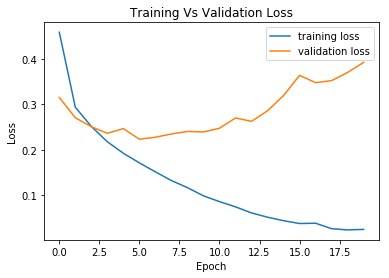

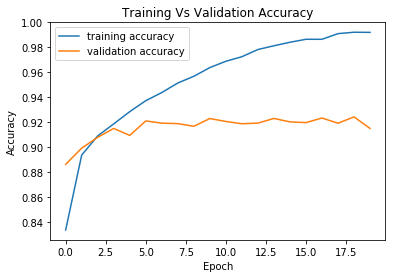

In [364]:
plt.plot(training.history['loss'], label='training loss')
plt.plot(training.history['val_loss'],label ='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Vs Validation Loss')
plt.show()

plt.figure()
plt.plot(training.history['acc'], label='training accuracy')
plt.plot(training.history['val_acc'],label ='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Vs Validation Accuracy')
plt.show()
#model.history['loss']


The plots above demonstrates that how our network can overfit as we keep training for more no. of epochs. 

Looking at the Training Vs Validation Loss plot we can see that the validation loss flattens out between epochs 5 - 10 & beyond that the validation loss will start increasing, even though the training error continues to decrease. This shows that this performance will not generalize outside the training set well & that we have passed the point at which model weights are being adjusted in a useful way. 

Similarly, looking at the Training Vs Validation Accuracy plot, we can see that initially the validation accuracy increased with loss but becomes stagnant after 5 epochs and does not increase after that. 

## To mitigate this we will use the callbacks module from Keras to save the best parameters  as well as adding Dropout layers to overcome the problem of overfitting.

### Model evaluation using overfit network parameters

In [365]:
score = model.evaluate(test_X, test_Y_1hot)

10000/10000 [==============================] - 4s 390us/step


In [366]:
print(model.metrics_names)
print(score)
print('Test Loss: ', score[0],'\nTest Accuracy: ', score[1])

['loss', 'acc']
[0.4484748521268368, 0.9095]
Test Loss:  0.4484748521268368 
Test Accuracy:  0.9095


#### To avoid overfitting issue discussed above we will save the best parameters using the callbacks module from Keras. We use the ModelCheckpoint API to save the model after every epoch. Set "save_best_only = True" to save only when the validation accuracy improves.

In [367]:
checkpoint = ModelCheckpoint('weights.hdf5', monitor = 'val_loss', save_best_only= True)
callbacks_list = [checkpoint]

In [368]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout
from keras.callbacks import ModelCheckpoint

model_dropout = Sequential()
model_dropout.add(Conv2D(64, kernel_size=3, padding ='same', activation ='relu', input_shape = (28, 28, 1)))
model_dropout.add(MaxPool2D(2))
model_dropout.add(Dropout(0.3))

model_dropout.add(Conv2D(32, kernel_size = 3, padding ='same', activation ='relu'))
model_dropout.add(MaxPool2D(2))
model_dropout.add(Dropout(0.3))

model_dropout.add(Flatten())
model_dropout.add(Dense(256, activation='relu'))
model_dropout.add(Dropout(0.5))

model_dropout.add(Dense(10, activation ='softmax'))

In [369]:
model_dropout.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model_dropout.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_89 (Conv2D)           (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 14, 14, 32)        18464     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_46 (Flatten)         (None, 1568)              0         
__________

In [370]:
training_dropout = model_dropout.fit(X_train,
                     y_train, 
                     batch_size=64, 
                     epochs = 20, 
                     validation_data=(X_valid,y_valid),
                     callbacks=callbacks_list)

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 70s 1ms/step - loss: 0.6007 - acc: 0.7829 - val_loss: 0.3653 - val_acc: 0.8644
Epoch 2/20
48000/48000 [==============================] - 68s 1ms/step - loss: 0.3982 - acc: 0.8550 - val_loss: 0.3042 - val_acc: 0.8868
Epoch 3/20
48000/48000 [==============================] - 69s 1ms/step - loss: 0.3479 - acc: 0.8730 - val_loss: 0.2791 - val_acc: 0.8978
Epoch 4/20
48000/48000 [==============================] - 67s 1ms/step - loss: 0.3195 - acc: 0.8840 - val_loss: 0.2708 - val_acc: 0.9011
Epoch 5/20
48000/48000 [==============================] - 67s 1ms/step - loss: 0.2997 - acc: 0.8895 - val_loss: 0.2508 - val_acc: 0.9052
Epoch 6/20
48000/48000 [==============================] - 67s 1ms/step - loss: 0.2856 - acc: 0.8961 - val_loss: 0.2446 - val_acc: 0.9075
Epoch 7/20
48000/48000 [==============================] - 77s 2ms/step - loss: 0.2737 - acc: 0.8986 - val_loss: 0.2426 - val_acc

In [371]:
# Saving the Model with Dropouts
model.save('model_dropout.h5py')

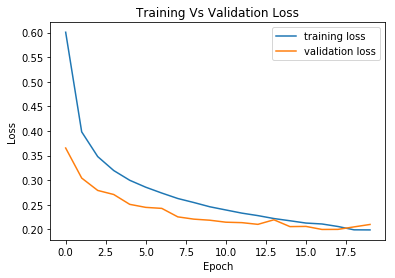

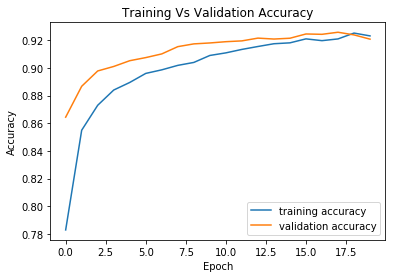

In [372]:
plt.plot(training_dropout.history['loss'], label='training loss')
plt.plot(training_dropout.history['val_loss'],label ='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Vs Validation Loss')
plt.show()

plt.figure()
plt.plot(training_dropout.history['acc'], label='training accuracy')
plt.plot(training_dropout.history['val_acc'],label ='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Vs Validation Accuracy')
plt.show()
#model.history['loss']

### Model evaluation using best parameters saved using callbacks with the best validation accuracy.

In [373]:
model_dropout.load_weights('weights.hdf5')
#model.predict_classes(test_Y_1hot)

In [374]:
score = model_dropout.evaluate(test_X, test_Y_1hot)


10000/10000 [==============================] - 4s 406us/step


In [375]:
print(model_dropout.metrics_names)
print(score)
print('Test Loss: ', score[0],'\nTest Accuracy: ', score[1])

['loss', 'acc']
[0.22418599103689194, 0.9165]
Test Loss:  0.22418599103689194 
Test Accuracy:  0.9165


On comparing we can see that using the model with the parameters that had the best validation accuracy our Loss is much lower, i.e. 0.244 compared to 0.5

In [480]:
predicted_classes = model_dropout.predict(test_X)
predicted_classes.shape


(10000, 10)

In [481]:
# Lets look at the predicted class results for the first image in the test data.
predicted_classes[0]

array([2.9195621e-09, 2.7242082e-09, 7.4813655e-11, 4.6130145e-11,
       4.7480499e-11, 9.9958879e-06, 2.5096375e-10, 3.5447760e-05,
       4.9082882e-12, 9.9995458e-01], dtype=float32)

### Each prediction(output of our model) is a 1d vector of size 10, with each element representing a "probability score". This score corresponds to the model’s confidence in assigning the particular class to the input example. 
Since the predictions are floating point values, we will first round off the output converting the float values into an integer.

In [484]:
predicted_class = np.argmax(np.round(predicted_classes),axis = 1)
predicted_class.shape

(10000,)

In [485]:
correct_prediction = np.where(predicted_class==test_Y)[0]
print('Found %d correct labels' % len(correct_prediction))


Found 9113 correct labels


In [486]:
incorrect_prediction = np.where(predicted_class != test_Y)[0]
print('Found %d incorrect labels' % len(incorrect_prediction))


Found 887 incorrect labels


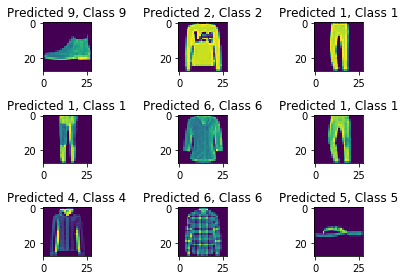

In [492]:
for i, correct in enumerate(correct_prediction[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[correct].reshape(28,28))
    plt.title("Predicted {}, Class {}".format(predicted_class[correct], test_Y[correct]))
    plt.tight_layout()
    
#predicted_class[0], test_Y[0]

In [488]:
incorrect_prediction[:9]

array([12, 23, 25, 26, 32, 40, 42, 49, 68], dtype=int64)

In [494]:
for i, incorrect in enumerate(incorrect_prediction[:9]):
    print(i,incorrect)

0 12
1 23
2 25
3 26
4 32
5 40
6 42
7 49
8 68


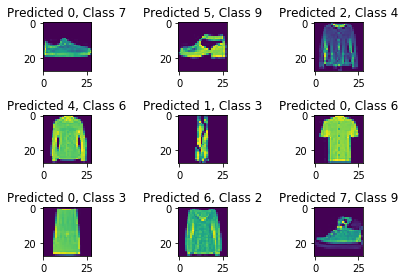

In [499]:
for i, incorrect in enumerate(incorrect_prediction[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(test_X[incorrect].reshape(28,28), interpolation='none')
    plt.title("Predicted {}, Class {}".format(predicted_class[incorrect], test_Y[incorrect]))
    plt.tight_layout()

#### Another way to visualize the predicted labels vs true labels 

In [507]:
# Define the text labels
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]

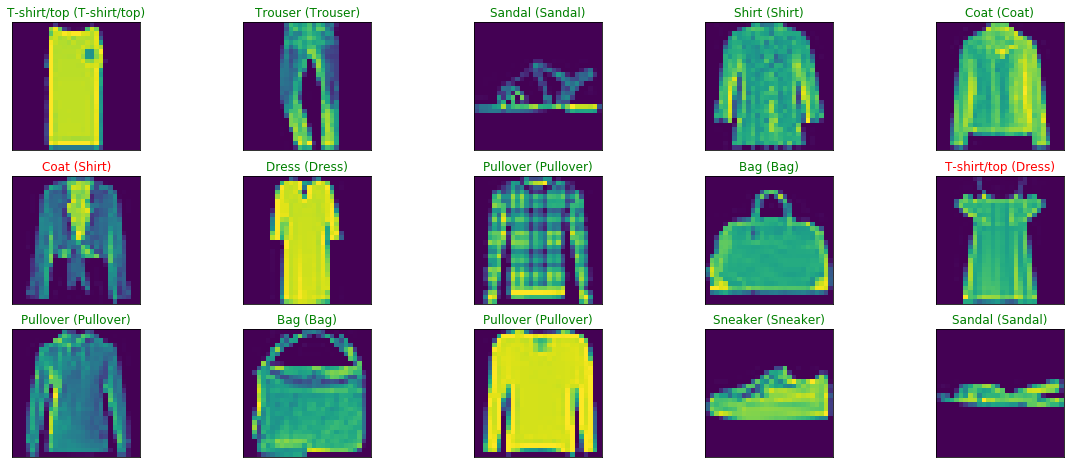

In [540]:
# Plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(test_X.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(test_X[index]))
    predict_index = predicted_class[index]
    true_index = test_Y[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(fashion_mnist_labels[predict_index], 
                                  fashion_mnist_labels[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

#### Looking at some of the images we can see that the missclassifications occur when similar features or patterns are observed among multiple classes. For example a Shirt is missclassified as a Coat or an ankle boot is missclassified as a sneaker. 

### Lets view the Classification Report & Confusion Matrix(Cross-Tabulation) to understand where the misclassifications occur more

In [501]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(n_classes)]
print(classification_report(test_Y, predicted_class, target_names=target_names))

             precision    recall  f1-score   support

    Class 0       0.74      0.93      0.82      1000
    Class 1       0.99      0.99      0.99      1000
    Class 2       0.88      0.87      0.88      1000
    Class 3       0.94      0.91      0.92      1000
    Class 4       0.85      0.88      0.86      1000
    Class 5       0.99      0.98      0.98      1000
    Class 6       0.85      0.64      0.73      1000
    Class 7       0.96      0.97      0.96      1000
    Class 8       0.99      0.98      0.98      1000
    Class 9       0.97      0.97      0.97      1000

avg / total       0.91      0.91      0.91     10000



### We can see that the classifier is underperforming  for Class 6 (Shirt) in both precision & recall. For Class 0, the classifier is lacking in precision.

In [576]:
pd.crosstab(test_Y,predicted_class, rownames=['True'],colnames=['Predicted'], margins = True)


Predicted,0,1,2,3,4,5,6,7,8,9,All
True,,,,,,,,,,,
0,927,1,7,9,3,1,48,1,3,0,1000
1,11,986,0,2,0,0,0,0,1,0,1000
2,50,1,873,5,43,0,28,0,0,0,1000
3,48,9,5,909,14,0,15,0,0,0,1000
4,23,1,46,25,880,0,25,0,0,0,1000
5,1,0,0,0,0,979,0,15,0,5,1000
6,178,2,55,17,100,0,643,0,5,0,1000
7,2,0,0,0,0,4,0,966,0,28,1000
8,12,0,1,2,1,4,0,1,979,0,1000


In [577]:
# Alternatively we can create a lookup for cross-tab using Label names

lookup ={0 :"T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8:"Bag", 9: "Ankle boot"}
y_TRUE_Label = pd.Series([lookup[_] for _ in test_Y])#labels=["T-shirt/top", "Trouser","Pullover", "Dress","Coat","Sandal","Shirt", "Sneaker","Bag","Ankle boot"])
Y_Predicted_Label = pd.Series([lookup[_] for _ in predicted_class])

In [581]:
pd.crosstab(y_TRUE_Label,Y_Predicted_Label, rownames=['True'],colnames=['Predicted'], margins = True)
# Note the label names will be arranged alphabetically, so will be in a different order that the previous cross-tab

Predicted,Ankle boot,Bag,Coat,Dress,Pullover,Sandal,Shirt,Sneaker,T-shirt/top,Trouser,All
True,,,,,,,,,,,
Ankle boot,971,0,0,0,0,4,1,24,0,0,1000
Bag,0,979,1,2,1,4,0,1,12,0,1000
Coat,0,0,880,25,46,0,25,0,23,1,1000
Dress,0,0,14,909,5,0,15,0,48,9,1000
Pullover,0,0,43,5,873,0,28,0,50,1,1000
Sandal,5,0,0,0,0,979,0,15,1,0,1000
Shirt,0,5,100,17,55,0,643,0,178,2,1000
Sneaker,28,0,0,0,0,4,0,966,2,0,1000
T-shirt/top,0,3,3,9,7,1,48,1,927,1,1000


### This matches our results from the classification report that the classifier underperforms for class 6 (Shirt) regarding both precision & recall.